In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "07_training/07d_distribute.ipynb"
_nb_title = "Distributed Training"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Distributed Training&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F07_training%2F07d_distribute.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F07_training%2F07d_distribute.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/07_training/07d_distribute.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/07_training/07d_distribute.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/07_training/07d_distribute.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Distributed Training

In this notebook, we show how to train the model on multiple GPUs.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print('TensorFlow version' + tf.version.VERSION)
print('Built with GPU support? ' + ('Yes!' if tf.test.is_built_with_cuda() else 'Noooo!'))
print('There are {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow version2.3.1
Built with GPU support? Yes!
There are 2 GPUs
Found GPU at: /device:GPU:0


## Create Strategy

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os, shutil
from tensorflow.data.experimental import AUTOTUNE

#PATTERN_SUFFIX, NUM_EPOCHS = '-0000[01]-*', 3 # small
PATTERN_SUFFIX, NUM_EPOCHS = '-*', 20 # full

IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()
BATCH_SIZE = 32

CHECKPOINT_DIR='./chkpts'
OUTDIR = './export'

def setup_trainer():
    shutil.rmtree(CHECKPOINT_DIR, ignore_errors=True)
    os.mkdir(CHECKPOINT_DIR)
    shutil.rmtree(OUTDIR, ignore_errors=True)
    os.mkdir(OUTDIR)
    # Load compressed models from tensorflow_hub
    os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'    

def create_strategy(mode='gpus_one_machine'):
    """
    mode has be to be one of the following:
    * gpus_one_machine
    * gpus_multiple_machines
    * tpu_colab
    * the actual name of the cloud_tpu
    """
    if mode == 'gpus_one_machine':
        print('Using {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))
        return tf.distribute.MirroredStrategy()
    if mode == 'gpus_multiple_machines':
        print("Using TFCONFIG=", os.environ["TF_CONFIG"])
        return tf.distribute.MultiWorkerMirroredStrategy()
    
    # treat as tpu
    if mode == 'tpu_colab':
        tpu_name = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    else:
        tpu_name = mode
    print("Using TPU: ", tpu_name)
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_name)
    tf.config.experimental_connect_to_cluster(resolver)
    # TPUs wipe out memory, so this has to be at very start of program
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
    return tf.distribute.TPUStrategy(resolver)

setup_trainer()
strategy = create_strategy()

Using 2 GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


## Training code

Streamlined from previous notebooks

In [4]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)

# most efficient way to read the data
# as determined in 07a_ingest.ipynb
# splits the files into two halves and interleaves datasets
def create_preproc_dataset(pattern):
    """
    Does interleaving, parallel calls, prefetch, batching
    Caching is not a good idea on large datasets.
    """
    preproc = _Preprocessor()
    files = [filename for filename
             # shuffle so that workers see different orders
             in tf.random.shuffle(tf.io.gfile.glob(pattern))
            ]
    
    if len(files) > 1:
        print("Interleaving the reading of {} files.".format(len(files)))
        def _create_half_ds(x):
            if x == 0:
                half = files[:(len(files)//2)]
            else:
                half = files[(len(files)//2):]
            return tf.data.TFRecordDataset(half,
                                          compression_type='GZIP')
        trainds = tf.data.Dataset.range(2).interleave(
            _create_half_ds, num_parallel_calls=AUTOTUNE)
    else:
        trainds = tf.data.TFRecordDataset(files,
                                         compression_type='GZIP')
    def _preproc_img_label(img, label):
        return (preproc.preprocess(img), label)
    
    trainds = (trainds
               .shuffle(200) # for distribution
               .map(preproc.read_from_tfr, num_parallel_calls=AUTOTUNE)
               .map(_preproc_img_label, num_parallel_calls=AUTOTUNE)
               .prefetch(AUTOTUNE)
              )
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)

class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        return images

In [5]:
def create_model(l1, l2, num_hidden):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
        
    layers = [
      tf.keras.layers.experimental.preprocessing.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.experimental.preprocessing.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
      RandomColorDistortion(name='random_contrast_brightness/none'),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    # checkpoint and early stopping callbacks
    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath='./chkpts',
        monitor='val_accuracy', mode='max',
        save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='max',
        patience=2)
    
    # create model
    return tf.keras.Sequential(layers, name='flower_classification')

def train_and_evaluate(strategy,
                       batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    
    train_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
    ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/valid' + PATTERN_SUFFIX
    ).batch(batch_size)

    # checkpoint and early stopping callbacks
    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath='./chkpts',
        monitor='val_accuracy', mode='max',
        save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='max',
        patience=3)
    
    # model training
    with strategy.scope():
        model = create_model(l1, l2, num_hidden)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=False),
                  metrics=['accuracy']
                 )
    print(model.summary())
    history = model.fit(train_dataset, 
                        validation_data=eval_dataset,
                        epochs=NUM_EPOCHS,
                        callbacks=[model_checkpoint_cb, early_stopping_cb]
                       )
    training_plot(['loss', 'accuracy'], history)
    return model

Interleaving the reading of 16 files.
Interleaving the reading of 2 files.
Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random/center_crop (RandomCr (None, 224, 224, 3)       0         
_________________________________________________________________
random_lr_flip/none (RandomF (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast_brightness/n (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable pa

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


     92/Unknown - 26s 279ms/step - loss: 0.9496 - accuracy: 0.6431INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 37s 405ms/step - loss: 0.9496 - accuracy: 0.6431 - val_loss: 0.6442 - val_accuracy: 0.7435
Epoch 2/20
91/92 [============================>.] - ETA: 0s - loss: 0.5487 - accuracy: 0.8073INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 36s 392ms/step - loss: 0.5472 - accuracy: 0.8088 - val_loss: 0.4940 - val_accuracy: 0.8005
Epoch 3/20
91/92 [============================>.] - ETA: 0s - loss: 0.4358 - accuracy: 0.8503INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 40s 430ms/step - loss: 0.4385 - accuracy: 0.8490 - val_loss: 0.4576 - val_accuracy: 0.8290
Epoch 4/20
92/92 [==============================] - 29s 317ms/step - loss: 0.4039 - accuracy: 0.8562 - val_loss: 0.4323 - val_accuracy: 0.8212
Epoch 5/20
91/92 [============================>.] - ETA: 0s - loss: 0.3648 - accuracy: 0.8723INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 36s 389ms/step - loss: 0.3646 - accuracy: 0.8722 - val_loss: 0.4257 - val_accuracy: 0.8342
Epoch 6/20
91/92 [============================>.] - ETA: 0s - loss: 0.3582 - accuracy: 0.8784INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 34s 375ms/step - loss: 0.3570 - accuracy: 0.8790 - val_loss: 0.4388 - val_accuracy: 0.8368
Epoch 7/20
91/92 [============================>.] - ETA: 0s - loss: 0.3270 - accuracy: 0.8867INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 36s 393ms/step - loss: 0.3258 - accuracy: 0.8872 - val_loss: 0.3849 - val_accuracy: 0.8472
Epoch 8/20
92/92 [==============================] - 29s 320ms/step - loss: 0.3198 - accuracy: 0.8882 - val_loss: 0.3961 - val_accuracy: 0.8446
Epoch 9/20
92/92 [==============================] - 29s 319ms/step - loss: 0.3110 - accuracy: 0.8926 - val_loss: 0.4020 - val_accuracy: 0.8394
Epoch 10/20
91/92 [============================>.] - ETA: 0s - loss: 0.3184 - accuracy: 0.8877INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 34s 374ms/step - loss: 0.3167 - accuracy: 0.8885 - val_loss: 0.3676 - val_accuracy: 0.8653
Epoch 11/20
92/92 [==============================] - 29s 314ms/step - loss: 0.2750 - accuracy: 0.9022 - val_loss: 0.3681 - val_accuracy: 0.8497
Epoch 12/20
92/92 [==============================] - 29s 314ms/step - loss: 0.2621 - accuracy: 0.9083 - val_loss: 0.3817 - val_accuracy: 0.8601
Epoch 13/20
91/92 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.8977INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 35s 380ms/step - loss: 0.2743 - accuracy: 0.8978 - val_loss: 0.3594 - val_accuracy: 0.8756
Epoch 14/20
92/92 [==============================] - 30s 323ms/step - loss: 0.2773 - accuracy: 0.9042 - val_loss: 0.3487 - val_accuracy: 0.8575
Epoch 15/20
92/92 [==============================] - 29s 320ms/step - loss: 0.2673 - accuracy: 0.9100 - val_loss: 0.3556 - val_accuracy: 0.8705
Epoch 16/20
92/92 [==============================] - 29s 319ms/step - loss: 0.2637 - accuracy: 0.9059 - val_loss: 0.3684 - val_accuracy: 0.8627


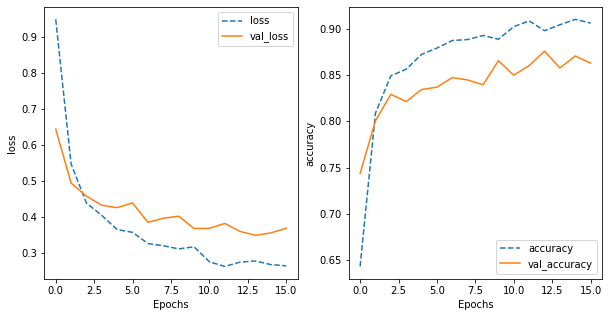

In [6]:
model = train_and_evaluate(strategy, batch_size=BATCH_SIZE)

In [7]:
@tf.function(input_signature=[tf.TensorSpec([None,], dtype=tf.string)])
def predict_flower_type(filenames):
    input_images = tf.map_fn(
        create_preproc_image,
        filenames,
        fn_output_signature=tf.float32
    )
    batch_pred = model(input_images) # same as model.predict()
    top_prob = tf.math.reduce_max(batch_pred, axis=[1])
    pred_label_index = tf.math.argmax(batch_pred, axis=1)
    pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES), pred_label_index)
    return {
        'probability': top_prob,
        'flower_type_int': pred_label_index,
        'flower_type_str': pred_label
    }

model.save(os.path.join(OUTDIR, 'flowers_model'),
          signatures={
              'serving_default': predict_flower_type
          })

INFO:tensorflow:Assets written to: ./export/flowers_model/assets


INFO:tensorflow:Assets written to: ./export/flowers_model/assets


## Try it out

In [8]:
serving_fn = tf.keras.models.load_model(
    os.path.join(OUTDIR, 'flowers_model')
).signatures['serving_default']
filenames = [
    'gs://cloud-ml-data/img/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://cloud-ml-data/img/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://cloud-ml-data/img/flower_photos/daisy/9158041313_7a6a102f7a_n.jpg',
    'gs://cloud-ml-data/img/flower_photos/daisy/9299302012_958c70564c_n.jpg',
    'gs://cloud-ml-data/img/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
    'gs://cloud-ml-data/img/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
]
pred = serving_fn(tf.convert_to_tensor(filenames))
print(pred)
print('******')
print(pred['flower_type_str'].numpy())

{'probability': <tf.Tensor: shape=(6,), dtype=float32, numpy=
array([0.87646186, 0.9998523 , 0.42461482, 0.9978123 , 0.9806886 ,
       0.9540813 ], dtype=float32)>, 'flower_type_int': <tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 1, 4, 0, 4, 4])>, 'flower_type_str': <tf.Tensor: shape=(6,), dtype=string, numpy=
array([b'daisy', b'dandelion', b'tulips', b'daisy', b'tulips', b'tulips'],
      dtype=object)>}
******
[b'daisy' b'dandelion' b'tulips' b'daisy' b'tulips' b'tulips']


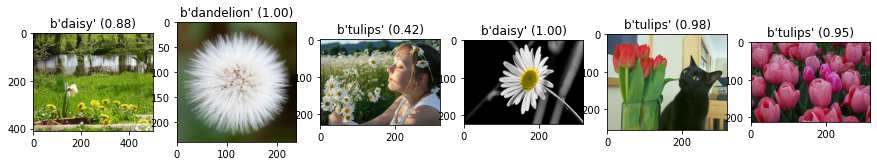

In [9]:
f, ax = plt.subplots(1, 6, figsize=(15,15))
for idx, (filename, prob, pred_label) in enumerate(
        zip(filenames, pred['probability'].numpy(), pred['flower_type_str'].numpy())):
    
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    ax[idx].imshow((img.numpy()));
    
    ax[idx].set_title('{} ({:.2f})'.format(pred_label, prob))    

## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.